<a href="https://colab.research.google.com/github/Sanket-Kakade/MovieGPT_using_AgenticRAG/blob/main/Agentic_RAG_Sanket.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install groq
!pip install chromadb
# !pip install langchain==0.2.0
!pip install langchain-openai #==0.1.7
!pip install -U langchain-community #==0.2.0
!pip install langgraph==0.1.1
!pip install langchain-chroma==0.1.1
!pip install -qU langchain-huggingface

In [ ]:
!pip install --upgrade "httpx<0.28"
!pip install -U sentence-transformers==2.6.0
!pip install InstructorEmbedding==1.0.1
!pip install -qU langchain-huggingface

In [ ]:
!pip install datasets

In [47]:
from datasets import Dataset, load_dataset

In [48]:
dataset = load_dataset("BrightData/IMDb-Media")

In [50]:
dataset_pd= dataset['train'].to_pandas()
# dataset_pd.drop('Unnamed: 0',axis=1,inplace=True )

In [51]:
print (dataset_pd.shape)
dataset_pd.head(3)

(249303, 31)


,title,popularity,genres,presentation,credit,videos,photos,top_cast,details_release_date,details_countries_of_origin,...,poster_url,imdb_rating_count,awards,critics_review_count,episode_count,review_count,review_rating,featured_review,storyline,boxoffice_budget
0,Devi Chowdhurani ... Bandit Queen of Bengal,NaN,"[""History""]",The untold story of the first woman freedom fi...,"[{""names"":[{""link"":""https://www.imdb.com/name/...",None,"[{""link"":""https://www.imdb.com/title/tt2779479...","[{""actor"":""Prasenjit Chatterjee"",""character"":""...",None,India,...,https://www.imdb.com/title/tt27794798/mediavie...,0,None,NaN,NaN,NaN,NaN,None,The untold story of the first woman freedom fi...,"$2,000,000.00"
1,Knit's Island,NaN,"[""Documentary""]",Somewhere on the internet is a land where comm...,"[{""names"":[{""link"":""https://www.imdb.com/name/...","[{""link"":""https://www.imdb.com/video/vi2827077...","[{""link"":""https://www.imdb.com/title/tt2748974...",None,4/17/2024 (France),France,...,https://www.imdb.com/title/tt27489748/mediavie...,116,4 wins && 6 nominations,6.0,NaN,NaN,NaN,None,Somewhere on the internet is a land where comm...,None
2,Fashion Reimagined,NaN,"[""Documentary""]","Follows Amy Powney, a daughter of environmenta...","[{""names"":[{""link"":""https://www.imdb.com/name/...","[{""link"":""https://www.imdb.com/video/vi2554053...","[{""link"":""https://www.imdb.com/title/tt1829298...","[{""actor"":""Chloe Marks"",""character"":""Self"",""li...",9/22/2023 (Japan),"United Kingdom, United States",...,https://www.imdb.com/title/tt18292986/mediavie...,139,3 wins && 3 nominations,11.0,NaN,3.0,10.0,This doc is a MUST watch! Not only does this f...,"Follows Amy Powney, a daughter of environmenta...",None


In [52]:
from google.colab import userdata
from langchain.embeddings import HuggingFaceInstructEmbeddings
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_openai import OpenAIEmbeddings


In [53]:
openai_api_key= userdata.get('OPENAI_API_KEY')
tavily_api_key= userdata.get('TRAVILY_API_KEY')

In [54]:
embeddings = HuggingFaceEmbeddings(model_name="BAAI/bge-large-en-v1.5")

In [ ]:
# file_path= '/content/drive/MyDrive/Sanket-DS/LLM_data/simplewiki-2020-11-01.jsonl.gz'

In [55]:
cols_to_fill= ['title','storyline','genres','presentation','details_countries_of_origin','details_language','imdb_rating','imdb_rating_count','awards']
for i in cols_to_fill:
  dataset_pd[i].fillna('Null',inplace=True)

<ipython-input-55-f35a0e9e8202>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset_pd[i].fillna('Null',inplace=True)
<ipython-input-55-f35a0e9e8202>:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Null' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dataset_pd[i].fillna('Null',inplace=True)


In [56]:
import gzip
import json
from langchain.docstore.document import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
docs = []
# with gzip.open(file_path, 'rt', encoding='utf8') as fIn:
#     for line in fIn:
#         data = json.loads(line.strip())
#         #Add documents
#         docs.append({
#                         'metadata': {
#                                         'title': data.get('title'),
#                                         'article_id': data.get('id')
#                         },
#                         'data': ' '.join(data.get('paragraphs')[0:3])
#         # restrict data to first 3 paragraphs to run later modules faster
#         })
for i in range(dataset_pd.shape[0]):
  docs.append({
                        'metadata': {

                                        'presentation': dataset_pd.loc[i,'presentation'],
                                        'details_countries_of_origin': dataset_pd.loc[i,'details_countries_of_origin']

                        },
                        'details': str({
                            'storyline': dataset_pd.loc[i,'storyline'],
                            'title': dataset_pd.loc[i,'title'],
                            'genres': dataset_pd.loc[i,'genres'].replace('["','"').replace('"]','"'),
                            'details_language': dataset_pd.loc[i,'details_language'],
                            'imdb_rating': dataset_pd.loc[i,'imdb_rating'],
                            'awards': dataset_pd.loc[i,'awards']

                        })

            })

In [57]:
docs= [i for i in docs if i['details'] is not None]

In [58]:
# # We subset our data to use a subset of wikipedia documents to run things faster
docs = [doc for doc in docs if doc['metadata']['details_countries_of_origin']=='India']
# Create docs
docs = [Document(page_content=doc['details'],
                 metadata=doc['metadata']) for doc in docs]


# Chunk docs
splitter = RecursiveCharacterTextSplitter(chunk_size=1500, chunk_overlap=300)
chunked_docs = splitter.split_documents(docs)
# chunked_docs[:3]

In [59]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
db_dir= '/content/drive/MyDrive/Sanket-DS/LLM_data/rag_imdb_IN_db_v2'

In [ ]:
# Enable this code when you want to create a new vector DB. Otherwise use the next cell to refer the existing DB.
# %%time
# from langchain_chroma import Chroma
# # create vector DB of docs and embeddings.
# batch_size = 41665  # Set to the maximum allowed batch size for Chroma DB

# for i in range(0, len(chunked_docs), batch_size):
#   batch = chunked_docs[i:i + batch_size]

# chroma_db = Chroma.from_documents(documents=batch,
#                                   collection_name='rag_imdb_db',
#                                   embedding=embeddings,
# # need to set the distance function to cosine else it uses Euclidean by default
# # check https://docs.trychroma.com/guides#changing-the-distance-function
#                                   collection_metadata={"hnsw:space": "cosine"},
#                                   persist_directory=db_dir)

CPU times: user 7min 9s, sys: 4.35 s, total: 7min 14s
Wall time: 7min 44s


In [ ]:
%%time
from langchain_chroma import Chroma

chroma_db = Chroma(collection_name='rag_imdb_db',persist_directory=db_dir, embedding_function=embeddings)


CPU times: user 1.19 s, sys: 105 ms, total: 1.29 s
Wall time: 5.53 s


In [ ]:
similarity_threshold_retriever = chroma_db.as_retriever(search_type="similarity_score_threshold",
                       search_kwargs={"k": 3,
                       "score_threshold": 0.2})
# We can then test if our retriever is working on some sample queries.

In [61]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI
# Data model for LLM output format
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""
    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )
# LLM for grading
llm = ChatOpenAI(base_url="https://api.groq.com/openai/v1",
  api_key=userdata.get('GROQ_API_KEY'),
  model="llama3-8b-8192")

structured_llm_grader = llm.with_structured_output(GradeDocuments)
# Prompt template for grading
SYS_PROMPT = """You are an expert grader assessing relevance of a retrieved document to a user question.
                Follow these instructions for grading:
                  - If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant.
                  - Your grade should be either 'yes' or 'no' to indicate whether the document is relevant to the question or not."""

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", SYS_PROMPT),
        ("human", """Retrieved document:
                     {document}
                     User question:
                     {question}
                  """),
    ]
)
# Build grader chain
doc_grader = (grade_prompt
                  |
              structured_llm_grader)

In [63]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.output_parsers import StrOutputParser
from operator import itemgetter
# Create RAG prompt for response generation
prompt = """You are an assistant for question-answering tasks, mainly on Indian movies.
            Use the following pieces of retrieved context to answer the question.
            If no context is present or if you don't know the answer, just say that you don't know the answer.
            Do not make up the answer unless it is there in the provided context.
            Give a detailed answer and to the point answer with regard to the question.
            Question:
            {question}
            Context:
            {context}
            Answer:
         """
prompt_template = ChatPromptTemplate.from_template(prompt)
# Initialize connection with GPT-4o
chatgpt = ChatOpenAI(base_url="https://api.groq.com/openai/v1",
  api_key=userdata.get('GROQ_API_KEY'),
  model="llama3-70b-8192")
# Used for separating context docs with new lines
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)
# create QA RAG chain
qa_rag_chain = (
    {
        "context": (itemgetter('context')
                        |
                    RunnableLambda(format_docs)),
        "question": itemgetter('question')
    }
      |
    prompt_template
      |
    chatgpt
      |
    StrOutputParser()
)

In [65]:
# The idea here is to get the user query, retrieve the context documents from the vector database or web search, and then send them as inputs to the RAG prompt mentioned above, which goes into GPT-4o to generate a human-like response. Let’s test out a few queries in our traditional RAG system now.
query = "what is the capital of India?"
query = "Suggest me good hindi war movies ? "

top3_docs = similarity_threshold_retriever.invoke(query)
result = qa_rag_chain.invoke(
    {"context": top3_docs, "question": query}
)
print(result)

Based on the provided context, here are some good Hindi war movies that I can suggest:

1. **Kurukshetra** (1999) - This movie is a Hindi war film with a high IMDB rating of 6.9. Although the storyline is not provided, the genres include Action, Drama, History, Musical, and War, making it a great option for those interested in war movies.

2. **Raag Desh** (2017) - This period film is based on the historic 1945 Indian National Army Red Fort Trials. With an impressive IMDB rating of 8.1 and one award win, it seems like a gripping and well-made war movie.

Please note that I did not suggest "Sher e Hindustan" as it is a Bhojpuri movie and not a Hindi movie, and its IMDB rating is relatively low (3.3).

I hope you enjoy these movie recommendations!


In [ ]:
# Let’s now try a question that is out of context, such that no context documents related to the question are there in the vector database.
query = "who won the champions league in 2024?"
top3_docs = similarity_threshold_retriever.invoke(query)
result = qa_rag_chain.invoke(
    {"context": top3_docs, "question": query}
)
print(result)


I don't know the answer. The provided context does not mention the Champions League or its winner in 2024. The context appears to be discussing films and sports teams, but there is no relevant information about the Champions League or its winners.


Create a Query Rephraser

In [66]:
# LLM for question rewriting
llm = ChatOpenAI(base_url="https://api.groq.com/openai/v1",
  api_key=userdata.get('GROQ_API_KEY'),
  model="llama3-8b-8192")
# Prompt template for rewriting
SYS_PROMPT = """Act as a question re-writer and perform the following task:
                 - Convert the following input question to a better version that is optimized for web search.
             """
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", SYS_PROMPT),
        ("human", """Here is the initial question:
                     {question}
                     Formulate an improved question. Your answer should not contain any supportive arguments or additional irrelevant text.
                  """,
        ),
    ]
)

# Create rephraser chain
question_rewriter = (re_write_prompt
                        |
                       llm
                        |
                     StrOutputParser())

In [67]:
#### Load Web Search Tool
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.utilities.tavily_search import TavilySearchAPIWrapper

tavilySearchAPIWrapper = TavilySearchAPIWrapper(tavily_api_key=tavily_api_key)
tv_search = TavilySearchResults(max_results=3, search_depth='advanced',max_tokens=10000,api_wrapper=tavilySearchAPIWrapper)

In [68]:
from typing import List
from typing_extensions import TypedDict
class GraphState(TypedDict):
    """
    Represents the state of our graph.
    Attributes:
        question: question
        generation: LLM response generation
        web_search_needed: flag of whether to add web search - yes or no
        documents: list of context documents
    """
    question: str
    generation: str
    web_search_needed: str
    documents: List[str]

In [85]:
def retrieve_IMDB_data(state):
    """
    Retrieve documents
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): New key added to state, documents - that contains retrieved context documents
    """
    print("---RETRIEVAL FROM VECTOR DB---")
    question = state["question"]
    # Retrieval
    documents = similarity_threshold_retriever.invoke(question)
    return {"documents": documents, "question": question}

In [86]:
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question
    by using an LLM Grader.
    If any document are not relevant to question or documents are empty - Web Search needs to be done
    If all documents are relevant to question - Web Search is not needed
    Helps filtering out irrelevant documents
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """
    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]
    # Score each doc
    filtered_docs = []
    web_search_needed = "No"
    if documents:
        print("---SOME DOCUMENTS RETRIEVED---")
        for d in documents:
            score = doc_grader.invoke(
                {"question": question, "document": d.page_content}
            )
            grade = score.binary_score
            if grade == "yes":
                print("---GRADE: DOCUMENT RELEVANT---")
                filtered_docs.append(d)
            else:
                print("---GRADE: DOCUMENT NOT RELEVANT---")
                web_search_needed = "Yes"
                continue
    else:
        print("---NO DOCUMENTS RETRIEVED---")
        web_search_needed = "Yes"
    return {"documents": filtered_docs, "question": question,
            "web_search_needed": web_search_needed}

In [87]:
def rewrite_query(state):
    """
    Rewrite the query to produce a better question.
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): Updates question key with a re-phrased or re-written question
    """
    print("---REWRITE QUERY---")
    question = state["question"]
    documents = state["documents"]
    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}

In [88]:
from langchain.schema import Document
def web_search(state):
    """
    Web search based on the re-written question.
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): Updates documents key with appended web results
    """
    print("---WEB SEARCH---")
    question = state["question"]
    documents = state["documents"]
    # Web search
    # print ("question :",question)
    docs = tv_search.invoke(question)
    # print ('docs :',docs)
    web_results = "\n\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)
    return {"documents": documents, "question": question}

In [89]:
def generate_answer(state):
    """
    Generate answer from context document using LLM
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE ANSWER---")
    question = state["question"]
    documents = state["documents"]
    # RAG generation
    generation = qa_rag_chain.invoke({"context": documents, "question": question})
    # print ("question ",question)
    # print ("documents ",documents)
    # print ("generation ",generation)

    return {"documents": documents, "question": question,
            "generation": generation}

In [90]:
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.
    Args:
        state (dict): The current graph state
    Returns:
        str: Binary decision for next node to call
    """
    print("---ASSESS GRADED DOCUMENTS---")
    web_search_needed = state["web_search_needed"]
    if web_search_needed == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("---DECISION: SOME or ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, REWRITE QUERY---")
        return "rewrite_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE RESPONSE---")
        return "generate_answer"

In [97]:
from langgraph.graph import END, StateGraph
agentic_rag = StateGraph(GraphState)
# Define the nodes
agentic_rag.add_node("retrieve IMDB data", retrieve_IMDB_data)  # retrieve
agentic_rag.add_node("grade retrieved documents", grade_documents)  # grade documents
agentic_rag.add_node("refine query using LLM", rewrite_query)  # transform_query
agentic_rag.add_node("web search", web_search)  # web search
agentic_rag.add_node("generate well rounded answer", generate_answer)  # generate answer
# Build graph
agentic_rag.set_entry_point("retrieve IMDB data")
agentic_rag.add_edge("retrieve IMDB data", "grade retrieved documents")
agentic_rag.add_conditional_edges(
    "grade retrieved documents",
    decide_to_generate,
    {"refine query using LLM": "refine query using LLM", "generate well rounded answer": "generate well rounded answer"},
)
agentic_rag.add_edge("refine query using LLM", "web search")
agentic_rag.add_edge("web search", "generate well rounded answer")
agentic_rag.add_edge("generate well rounded answer", END)
# Compile
agentic_rag = agentic_rag.compile()

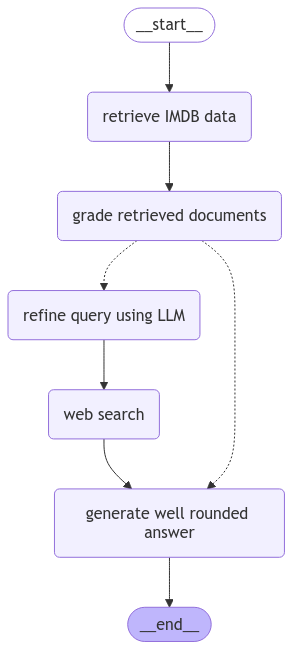

In [98]:
from IPython.display import Image, display, Markdown
display(Image(agentic_rag.get_graph().draw_mermaid_png()))


In [79]:
query = "Suggest me good and latest hindi war/patriotic movies. "
response = agentic_rag.invoke({"question": query})
print (response['generation'])

---RETRIEVAL FROM VECTOR DB---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---SOME DOCUMENTS RETRIEVED---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: SOME or ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, REWRITE QUERY---
---REWRITE QUERY---
---WEB SEARCH---
---GENERATE ANSWER---
Based on the provided context, I don't see any information about the "latest" Hindi patriotic movies. The context provides information about various patriotic movies, but it doesn't specify the latest ones. The dates mentioned in the context are from 1982, 2000, 2004, 2006, and 2013, which are not recent.

However, I can provide you with some popular Hindi patriotic movies mentioned in the context:

1. Swades (2004)
2. Rang De Basanti (2006)
3. Gandhi (1982)
4. Mission Kashmir (2000)
5. Bhaag Milkha Bhaag (2013)

If you're looking for the latest Hindi patriotic movies, I would recommend searching online for more rec

In [80]:
query = "Can you help me with the storyline of the movie 3 idiots?"

response = agentic_rag.invoke({"question": query})
print (response['generation'])

---RETRIEVAL FROM VECTOR DB---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---SOME DOCUMENTS RETRIEVED---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: SOME or ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, REWRITE QUERY---
---REWRITE QUERY---
---WEB SEARCH---
---GENERATE ANSWER---
Based on the provided context, here is a summary of the plot of the Bollywood movie "3 Idiots" (2009) directed by Rajkumar Hirani:

The movie revolves around the friendships of three friends, Rancho (played by Aamir Khan), Farhan, and Raju, as they navigate through one of the prestigious colleges of the Indian Institutes of Technology. The film is a comedy-drama that explores the challenges and experiences of these three friends as they manage the demands of college life.

Unfortunately, the provided context does not offer more details about the plot, so I couldn't provide a more comprehensive summary. If you ha

In [81]:
query = "Can you suggest me some critically acclaimed biography movies in Marathi ?"

response = agentic_rag.invoke({"question": query})
print (response['generation'])

---RETRIEVAL FROM VECTOR DB---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---SOME DOCUMENTS RETRIEVED---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE RESPONSE---
---GENERATE ANSWER---
Based on the provided context, here are some critically acclaimed biography movies in Marathi that I would suggest:

1. **Mahatma Phule** (IMDB rating: 9.4) - A biopic based on the life of social reformer and revolutionary activist Jyotirao Govindrao Phule, who aspired to attain equality for the people and was considered a pioneer of women's education.
2. **Satyashodhak** (IMDB rating: 8.6) - A biographical journey depicting the life of Mahatma Jyotirao Phule.
3. **Bhai - Vyakti Ki Valli** (IMDB rating: 7.9) - A biopic of Marathi comedian, India's first stand-up comedian P. L. Deshpande, which also explores his personal life.

All three movies are highly rated and critically acclaimed, making them great cho

In [82]:
query = "Give me names of movies which are prt of Golmaal series, the one which has Ajay Devgan in it."

response = agentic_rag.invoke({"question": query})
print (response['generation'])

---RETRIEVAL FROM VECTOR DB---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---SOME DOCUMENTS RETRIEVED---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: SOME or ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, REWRITE QUERY---
---REWRITE QUERY---
---WEB SEARCH---
---GENERATE ANSWER---
According to the provided context, the movies in the Golmaal series that star Ajay Devgn are:

1. Golmaal: Fun Unlimited (2006)
2. Golmaal Returns (2008)
3. Golmaal 3 (2010)
4. Golmaal Again (2017)

All of these movies feature Ajay Devgn in a starring role.


In [84]:
query = "Can you give me all the movies from India nominated for Oscar post 2010."

response = agentic_rag.invoke({"question": query})
print (response['generation'])

---RETRIEVAL FROM VECTOR DB---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---SOME DOCUMENTS RETRIEVED---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: SOME or ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, REWRITE QUERY---
---REWRITE QUERY---
---WEB SEARCH---
---GENERATE ANSWER---
Based on the provided context, the Indian movies nominated for the Academy Award (Oscar) after 2010 are not explicitly mentioned. The context only mentions three Indian movies that were nominated for Oscars, but they were all before 2010: Mother India (1957), Salaam Bombay (1988), and Lagaan (2001). 

However, it is mentioned that "Laapataa Ladies" is India's official entry for Oscars 2025, which means it is a nomination for the Academy Award, but it is not clear if it has been officially nominated or just selected as India's entry.

Therefore, I don't know the answer to the question as the context does not prov